In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt # matplotlib for plotting
import re # regular expressions

import warnings
warnings.filterwarnings("ignore") #because who likes annoying warnings

plt.style.use('ggplot') #prettier pictures

import datetime      #for datetime operations
import calendar      #for calendar for datetime operations
import time          #to get the system time
plt.rcParams['figure.figsize'] = [16, 10] #set default figure size

from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

In [2]:
df = pd.read_csv('../data/clean_train.csv')

In [3]:
#some datetime manipulations
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)
df['date'] = pd.to_datetime(df.date)

In [4]:
df['Hour'] = df['pickup_datetime'].dt.hour
df['dayofweek'] = df['pickup_datetime'].dt.dayofweek
df['Month'] = df['pickup_datetime'].dt.month
df['dayofyear'] = df['pickup_datetime'].dt.dayofyear

Text(0.5, 1.0, 'Number of Rides over the Year')

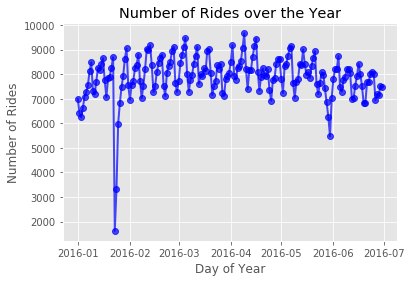

In [5]:
#plotting number of rides over the course of January to June

plt.plot(df.groupby('date').count()['id'], 'bo-', lw=2, alpha=0.7)
plt.xlabel('Day of Year')
plt.ylabel('Number of Rides')
plt.title('Number of Rides over the Year')

# Seasonal Adjustment with Differencing

Our time series contains weekly seasonal variation, which are cycles that repeat regularly over time. 

In [6]:
count =  df.groupby('date').count()['id']
series = pd.DataFrame(({'day': count.index, 'count': count.values})).set_index('day')
series.head()

,count
day,
2016-01-01,6993
2016-01-02,6415
2016-01-03,6238
2016-01-04,6620
2016-01-05,7088


Since the weekly seasonality of our time series has been identified, it can be modeled.<br>
The model of seasonality can be removed from the time series. This process is called seasonal adjustment. <br>
A time series were the seasonal component has been removed is called seasonal stationary.<br>    

In the plot below, we consider that every month, there is a seasonal trend that repeats itself. We will take out the first month of values (becuase there is no prior month before that) and subtract the following values by the value of the number of rides of the day that came 30 days prior to it. 

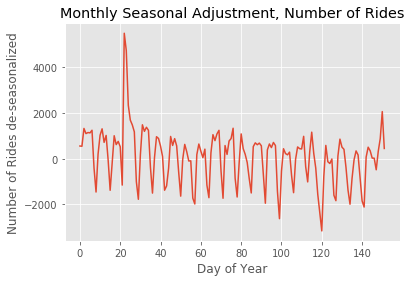

In [7]:
#Differncing by week for seasonal adjustment

X = series.values
diff = list()
days_in_month =30
for i in range(days_in_month, len(X)):
    value = X[i] - X[i - days_in_month]
    diff.append(value)
plt.plot(diff)
plt.xlabel('Day of Year')
plt.ylabel('Number of Rides de-seasonalized')
plt.title('Monthly Seasonal Adjustment, Number of Rides')
plt.show()

We can also consider the number fo rides within any given period of the year is probably stable. We can take this idea and consider all number of rides within a week to be stable. We can then subtract the average weekly number of rides from the previous week. 

Resample the dataset to a weekly average:

                  count
day                    
2016-01-03  6548.666667
2016-01-10  7493.000000
2016-01-17  8017.142857
2016-01-24  6385.428571
2016-01-31  7633.571429
2016-02-07  7912.000000
2016-02-14  8328.142857
2016-02-21  8045.000000
2016-02-28  8242.714286
2016-03-06  8399.571429
2016-03-13  8133.714286
2016-03-20  8333.142857
2016-03-27  7805.142857


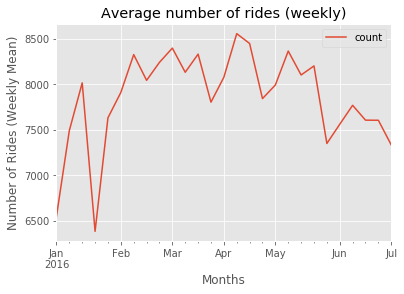

In [8]:
resample = series.resample('W')
weekly_mean = resample.mean()
print(weekly_mean.head(13))
weekly_mean.plot()
plt.xlabel('Months')
plt.ylabel('Number of Rides (Weekly Mean)')
plt.title('Average number of rides (weekly)')
plt.show()

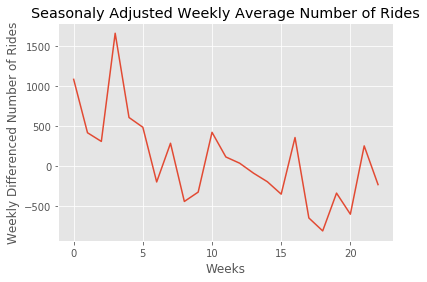

In [9]:
resample = series.resample('W')
weekly_mean = resample.mean()

diff = list()
weeks_in_month = 4
for i in range(weeks_in_month , len(weekly_mean)):
    value = weekly_mean.values[i] - weekly_mean.values[i - weeks_in_month]
    diff.append(value)
plt.plot(diff)
plt.xlabel('Weeks')
plt.ylabel('Weekly Differenced Number of Rides')
plt.title('Seasonaly Adjusted Weekly Average Number of Rides')
plt.show()

The above plot shows a new seasonaly adjusted weekly average number of rides, skipping the first four weeks of data in order to create the adjustment (We subtract the weekly mean value of our adjustment by the weekly mean value of the data 4 weeks prior)

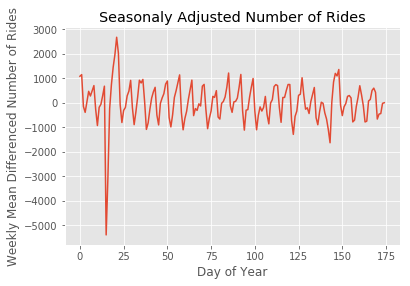

In [10]:
X = series.values
diff = list()
days_in_week = 7

for i in range(days_in_week, len(X)):
    date_ind = series.index[i].dayofyear
    last_week_mean = series.iloc[date_ind - 7 : date_ind].mean()
    value = X[i] - last_week_mean
    diff.append(value)

plt.plot(diff)
plt.xlabel('Day of Year')
plt.ylabel('Weekly Mean Differenced Number of Rides')
plt.title('Seasonaly Adjusted Number of Rides')
plt.show()

We can use the weekly average number of rides data to make this adjustment to the daily vlaues. The first week of values has been skipped (since they dont have a previous week of values to average and subtract by), and the rest of the values were subtracted by the average values of the number of rides of the 7 days prior to that day. This type of differencing makes the dataset more robust to daily fluctuations. It can be improved upon by using other metrics, such as previous month's mean, etc. 

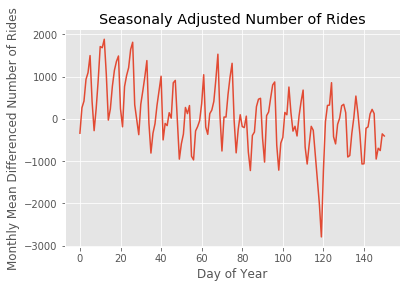

In [11]:
X = series.values
diff = list()
days_in_year = 31
for i in range(days_in_year, len(X)):
    month_str = str(series.index[i].year)+'-'+str(series.index[i].month- 1)
    month_mean_last_month = series[month_str].mean()
    value = X[i] - month_mean_last_month
    diff.append(value)
plt.plot(diff)
plt.xlabel('Day of Year')
plt.ylabel('Monthly Mean Differenced Number of Rides')
plt.title('Seasonaly Adjusted Number of Rides')
plt.show()

Here, we skipped the first month of data, averaged the previous month of number of rides, and then subtracted the value from the following days' number of rides. 

# Seasonal Adjustment with Modeling

We can model the seasonal component directly as a sine wave over a generally fixed period and amplitude. We can choose a single week/month of data, or all of the data. We could also smooth the observations using a moving average centered on each value. 

When using np.polyfit(), a consistent sine wave can usually be modeled by using order 4 or 5.

In [105]:
count1 =  df.groupby('date').count()['id']
series1 = pd.DataFrame(({'day': count1.index, 'count': count1.values}))
series1.head()

,day,count
0,2016-01-01,6993
1,2016-01-02,6415
2,2016-01-03,6238
3,2016-01-04,6620
4,2016-01-05,7088


In [106]:
series1.index.shape

(182,)

In [107]:
x_new =  series1.index.copy()

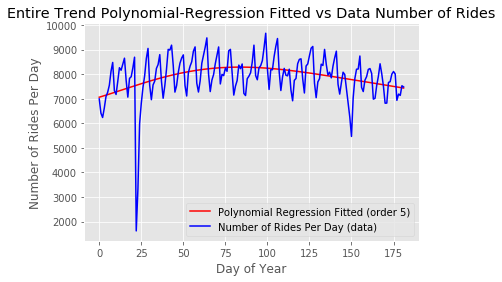

In [109]:
import numpy.polynomial.polynomial as poly
coefs = poly.polyfit(series1.index, series1['count'], 5)
ffit = poly.polyval(x_new, coefs)
plt.plot(x_new, ffit, color= 'red', label = 'Polynomial Regression Fitted (order 5)')
plt.plot(series.values, color= 'blue' , label = 'Number of Rides Per Day (data)')
plt.xlabel('Day of Year')
plt.ylabel('Number of Rides Per Day')
plt.title('Entire Trend Polynomial-Regression Fitted vs Data Number of Rides')
plt.legend()
plt.show()


np.polyfit cannot fit the regression line properly at the bigger scale, let's look at a week of increments, using the average values.

In [62]:
df['dayofweek'] = df['pickup_datetime'].dt.dayofweek

In [63]:
print('Tootal weeks in the duration of the time series : %i' %(len(series)/7))

Tootal weeks in the duration of the time series : 26


In [64]:
count2 =  df.groupby('dayofweek').count()['id']
series2 = pd.DataFrame(({'day': count2.index, 'count': count2.values / 26}))
series2.head()

,day,count
0,0,7103.846154
1,1,7687.115385
2,2,7968.769231
3,3,8280.192308
4,4,8468.269231


In [65]:
x_new1 =  series2.index.copy()

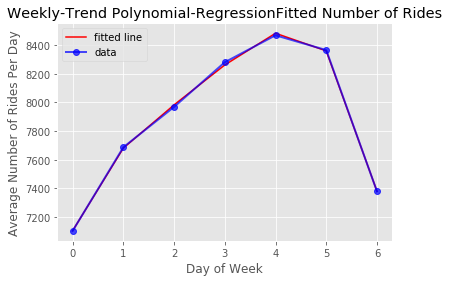

In [104]:
coefs = poly.polyfit(series2.index, series2['count'], 5)
ffit = poly.polyval(x_new1, coefs)
plt.plot(x_new1, ffit, color= 'red', label = 'fitted line')
plt.plot(df.groupby('dayofweek').count()['id'].index, (df.groupby('dayofweek').count()['id'].values / 26) , 'bo-', lw=2, alpha=0.7, label = 'data')
plt.legend()
plt.xlabel('Day of Week')
plt.ylabel('Average Number of Rides Per Day')
plt.title('Weekly-Trend Polynomial-RegressionFitted Number of Rides')
plt.show()
plt.show()

In [45]:
#ffit = poly.Polynomial(coefs)    # instead of np.poly1d
#plt.plot(x_new1, ffit(x_new1))

Create a dataframe of the indexed day of weeks and the fitted average count values

In [70]:
deseason = pd.DataFrame(({'dayofweek': x_new1 , 'fitted_count': ffit}))
deseason.head(7)


,dayofweek,fitted_count
0,0,7104.795871
1,1,7681.417083
2,2,7983.014985
3,3,8261.197969
4,4,8482.514985
5,5,8359.301698
6,6,7380.526640


In [82]:
count1 =  df.groupby('date').count()['id']
final = pd.DataFrame(({'day': count1.index, 'count': count1.values}))

Create a day of week column for a dataset that contains the entire data from January to June

In [95]:
final['dayofweek'] = final['day'].dt.dayofweek

In [93]:
final.head(10)

,day,count,dayofweek
0,2016-01-01,6993,4
1,2016-01-02,6415,5
2,2016-01-03,6238,6
3,2016-01-04,6620,0
4,2016-01-05,7088,1
5,2016-01-06,7262,2
6,2016-01-07,7550,3
7,2016-01-08,8117,4
8,2016-01-09,8479,5
9,2016-01-10,7335,6


Merge such that the final dataframe will contain both the actual count values for each day, and the corresponding fitted polynomial values for the day of week value resides in

In [98]:
final_df = pd.merge(final,
                    deseason[['dayofweek', 'fitted_count']],
                    left_on = 'dayofweek',
                    right_on = 'dayofweek',
                    how = 'left')


In [101]:
final_df['final_count'] = (round(final_df['count'] - final_df['fitted_count']))

In [102]:
final_df.head(10)

,day,count,dayofweek,fitted_count,final_count
0,2016-01-01,6993,4,8482.514985,-1490.0
1,2016-01-02,6415,5,8359.301698,-1944.0
2,2016-01-03,6238,6,7380.526640,-1143.0
3,2016-01-04,6620,0,7104.795871,-485.0
4,2016-01-05,7088,1,7681.417083,-593.0
5,2016-01-06,7262,2,7983.014985,-721.0
6,2016-01-07,7550,3,8261.197969,-711.0
7,2016-01-08,8117,4,8482.514985,-366.0
8,2016-01-09,8479,5,8359.301698,120.0
9,2016-01-10,7335,6,7380.526640,-46.0


Plot the resulting weekly trend polynomial-regression subtracted deseasonalized data.

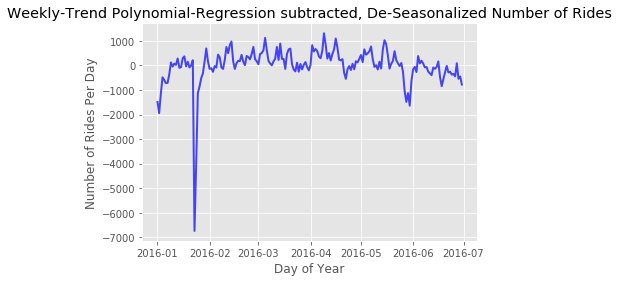

In [103]:
plt.plot(final_df.day, final_df.final_count , 'b-', lw=2, alpha=0.7)
plt.xlabel('Day of Year')
plt.ylabel('Number of Rides Per Day')
plt.title('Weekly-Trend Polynomial-Regression subtracted, De-Seasonalized Number of Rides')
plt.show()